### https://www.jiqizhixin.com/articles/2018-03-05-3

In [69]:
import pandas as pd

In [70]:
df = pd.read_csv("Consumer_Complaints.csv")
df.head()

F:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Submitted via,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
0,1114245,Debt collection,Medical,Disclosure verification of debt,Not given enough info to verify debt,FL,32219.0,Web,11/13/2014,11/13/2014,"Choice Recovery, Inc.",Closed with explanation,Yes,NaN
1,1114488,Debt collection,Medical,Disclosure verification of debt,Right to dispute notice not received,TX,75006.0,Web,11/13/2014,11/13/2014,"Expert Global Solutions, Inc.",In progress,Yes,NaN
2,1114255,Bank account or service,Checking account,Deposits and withdrawals,NaN,NY,11102.0,Web,11/13/2014,11/13/2014,"FNIS (Fidelity National Information Services, ...",In progress,Yes,NaN
3,1115106,Debt collection,"Other (phone, health club, etc.)",Communication tactics,Frequent or repeated calls,GA,31721.0,Web,11/13/2014,11/13/2014,"Expert Global Solutions, Inc.",In progress,Yes,NaN
4,1115890,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,FL,33461.0,Web,11/12/2014,11/13/2014,TransUnion,In progress,Yes,NaN


In [71]:
from io import StringIO

col = ["Product", "Sub-issue"]
df = df[col]
df = df[pd.notnull(df["Sub-issue"])]
df.columns = ["Product", "Sub_issue"]

In [72]:
df["category_id"] = df["Product"].factorize()[0]
category_id_df = df[["Product", "category_id"]].drop_duplicates().sort_values("category_id")
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[["category_id", "Product"]].values)
df["Product"].unique()

array(['Debt collection', 'Credit reporting'], dtype=object)

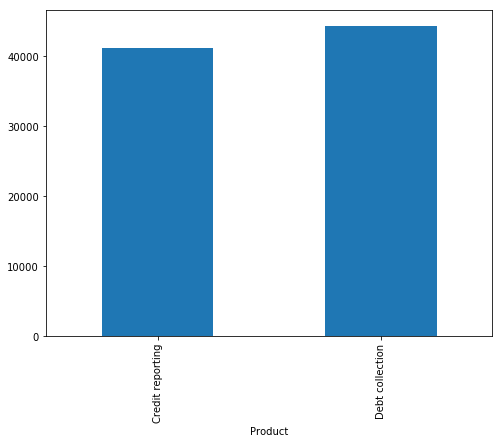

In [73]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
df.groupby("Product")["Sub_issue"].count().plot.bar(ylim=0)
plt.show()

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer


### sublinear_df 设为 True 从而使用频率的对数形式。

### min_df 是单词必须存在的最小文档数量。

### norm 设为 l2，以确保我们所有特征向量的欧几里德范数为 1。

### ngram_range 设为 (1, 2)，表示我们想要考虑 unigrams 和 bigrams。

### stop_words 设为 "english" 来删除所有常用代词 ("a", "the", ...) 以减少噪音特征的数量。

In [81]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm="l2",
                       encoding="latin-1", ngram_range=(1,2), stop_words="english")

features = tfidf.fit_transform(df["Sub_issue"]).toarray()
labels = df.category_id
features.shape

(85586, 220)

In [82]:
from sklearn.feature_selection import chi2
import numpy as np

In [116]:
N = 2

for Product, category_id in sorted(category_to_id.items()):
    
    features_chi2 = chi2(features, labels==category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(" ")) == 1]
    bingrams = [v for v in feature_names if len(v.split(" ")) == 2]
    print("# '{}:'".format(Product))
    print(". Most  correlated unigrams:\n. {}".format("\n.".join(unigrams[-N:])))
    print(". Most correlated bingrams:\n. {}".format("\n.".join(bingrams[-N:])))
    

# 'Credit reporting:'
. Most  correlated unigrams:
. information
.debt
. Most correlated bingrams:
. debt paid
.account status
# 'Debt collection:'
. Most  correlated unigrams:
. information
.debt
. Most correlated bingrams:
. debt paid
.account status


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df["Sub_issue"], df["Product"], random_state=0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [100]:
print(clf.predict(count_vect.transform(["This company refuses to provide me\
                                        verification and validation of debt per my right under the FDCPA.\
                                        I do not believe this debt is mine"])))
                                        

['Debt collection']


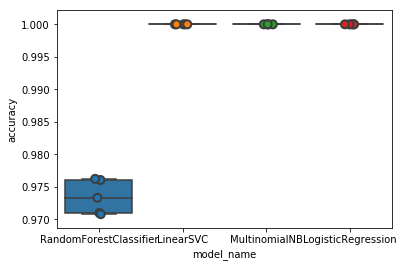

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring="accuracy", cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

import seaborn as sns
sns.boxplot(x="model_name", y="accuracy", data=cv_df)
sns.stripplot(x="model_name", y="accuracy", data=cv_df,
             size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [103]:
cv_df.groupby("model_name").accuracy.mean()

model_name
LinearSVC                 1.000000
LogisticRegression        1.000000
MultinomialNB             1.000000
RandomForestClassifier    0.973465
Name: accuracy, dtype: float64

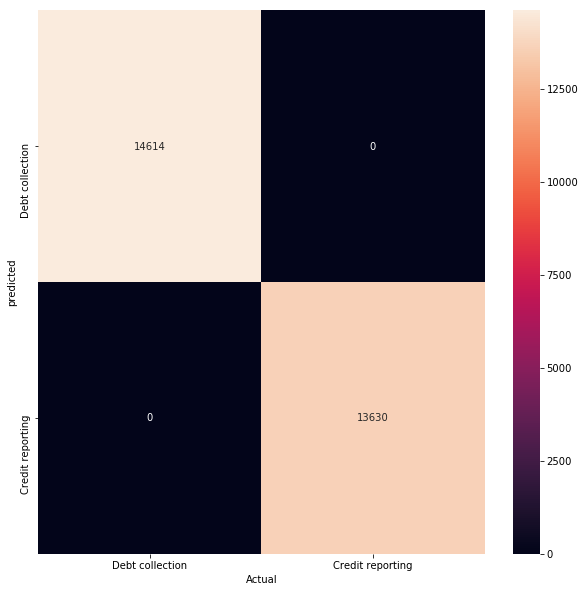

In [104]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
                    features, labels, df.index, test_size=0.33,random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt="d",
           xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.xlabel("Actual")
plt.ylabel("predicted")
plt.show()

In [105]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                  precision    recall  f1-score   support

 Debt collection       1.00      1.00      1.00     14614
Credit reporting       1.00      1.00      1.00     13630

     avg / total       1.00      1.00      1.00     28244

